In [1]:
from matplotlib import pyplot as plt
from itertools import product
import seaborn as sns
import numpy as np
import pandas as pd
import os.path as op
import argparse
import re
# EEG utilities
import mne
from pycrostates.cluster import ModKMeans
from pycrostates.io import read_cluster, ChData
# BIDS utilities
from util.io.bids import DataSink
from bids import BIDSLayout

In [2]:
# constants
BIDS_ROOT = '../data/bids'
DERIV_ROOT = op.join(BIDS_ROOT, 'derivatives')
FFR_PASSBAND = (30., 300.)
MICROSTATE_PASSBAND = (1., 30.)
TASK = 'pitch'
layout = BIDSLayout(BIDS_ROOT, derivatives = True)

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


In [3]:
# get filenames for subject-level microstates
fpaths = layout.get(return_type = 'filename', desc = 'microstates')
# and sort by subject number
sub_num = lambda f: int(re.findall('sub-(\w+)_', f)[0])
fpaths.sort(key = sub_num)

In [4]:
# load cluster centers for individually computed miscrostates
clusts_indiv = [read_cluster(f) for f in fpaths]
centers_indiv = [clust.cluster_centers_ for clust in clusts_indiv]
group_cluster_centers = np.vstack(centers_indiv).T
group_cluster_centers = ChData(group_cluster_centers, clusts_indiv[0].info)
# drop channel marked as Iz in first subject, since this electrode
# has an inconsistent location between subjects (sometimes placed at FCz)
group_cluster_centers = group_cluster_centers.pick(None, exclude = ['Iz'])

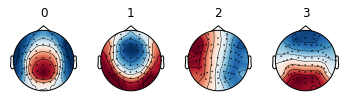

In [5]:
# group level clustering
ModK = ModKMeans(n_clusters = 4, random_state = 0)
ModK.fit(group_cluster_centers, n_jobs = -1)
ModK.plot()
plt.show()

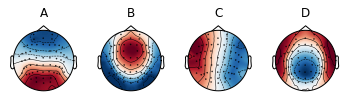

In [6]:
# re-order based on visual similarity to canonical microstates topographies 
ModK.reorder_clusters(order = [3, 1, 2, 0])
ModK.rename_clusters(new_names = ['A', 'B', 'C', 'D'])
ModK.invert_polarity([False, True, False, True]) # only affects visualization
ModK.plot()
plt.show()

In [9]:
# save solution
clust_fpath = op.join(DERIV_ROOT, 'microstates', 'clusters_group_2.fif.gz')
ModK.save(clust_fpath)

In [7]:
subs = layout.get_subjects()
subs.sort(key = int)
sub = subs[10]

In [8]:
def read_epochs(sub, desc):
    '''
    reads and concatenates epochs across runs
    '''
    layout = BIDSLayout(BIDS_ROOT, derivatives = True)
    run = lambda f: int(re.findall('run-(\w+)_', f)[0])
    fnames = layout.get(
        return_type = 'filename',
        subject = sub, 
        desc = desc
        )
    print(fnames)
    fnames.sort(key = run)
    epochs_all = [mne.read_epochs(f) for f in fnames]
    epochs = mne.concatenate_epochs(epochs_all)
    epochs = epochs.pick('eeg')
    return epochs

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-12/sub-12_task-pitch_run-1_desc-forFFR_epo.fif.gz']


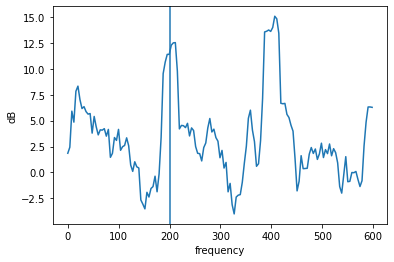

In [10]:
def compute_spectrum_dB(epo):
    '''
    Computes power spectrum of frequency following response
    '''
    poststim = epo.average().compute_psd(tmin = 0., tmax = 0.25)
    baseline = epo.average().compute_psd(tmin = -0.25, tmax = 0.)
    power = 10 * np.log10(poststim.get_data() / baseline.get_data())
    power = np.squeeze(power)
    return poststim.freqs, power

# plot an example
stim_freq = 200
epochs = read_epochs(sub, 'forFFR')
freqs, spectrum = compute_spectrum_dB(epochs[str(stim_freq)])
plt.plot(freqs, spectrum)
plt.xlabel('frequency')
plt.ylabel('dB')
plt.axvline(stim_freq)
plt.show()

/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-12/sub-12_task-pitch_run-1_desc-forFFR_epo.fif.gz']


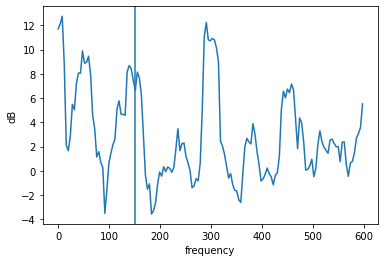

In [11]:
# plot an example
stim_freq = 150
epochs = read_epochs(sub, 'forFFR')
freqs, spectrum = compute_spectrum_dB(epochs[str(stim_freq)])
plt.plot(freqs, spectrum)
plt.xlabel('frequency')
plt.ylabel('dB')
plt.axvline(stim_freq)
plt.show()

In [15]:
subs = layout.get_subjects(scope = 'microstates')
subs.sort(key = int)
    
all_spectrums = []

for sub in subs:

    # get last microstate observed before each stimulus is delivered
    try:
        epochs = read_epochs(sub, 'forMicrostate')
    except:
        print(f'Skipping sub {sub}')
        continue
    segmentation = ModK.predict(epochs, reject_edges = False)
    labels = [segmentation.cluster_names[idx] for idx in segmentation.labels[:, -1]]

    # read FFR epochs and assign microstate labels
    epochs = read_epochs(sub, 'forFFR')
    mapping = {epochs.event_id[key]: key for key in epochs.event_id}
    event_names = np.array([mapping[ev] for ev in epochs.events[:, -1]])
    df = pd.DataFrame({'stimulus': event_names, 'microstate': labels})
    epochs.metadata = df

    # compute FFR spectrums for each microstate x stim
    micros = segmentation.cluster_names
    stims = np.unique(event_names)
    for microstate, stim in product(micros, stims):
        try:
            epo = epochs["microstate == '%s'"%microstate][stim]
        except:
            continue
        freqs, spectrum = compute_spectrum_dB(epo)
        df = pd.DataFrame(
            {'subject': sub,
             'stimulus': int(stim),
             'microstate': microstate,
             'frequency': freqs,
             'power': spectrum
            }
        )
        all_spectrums.append(df)

# compile into one big dataframe and save for later
spectrums = pd.concat(all_spectrums)
# spectrums.to_csv('spectrums_2.csv', sep = '\t', index = False)



/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-3/sub-3_task-pitch_run-1_desc-forMicrostate_epo.fif.gz', '/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-3/sub-3_task-pitch_run-2_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-3/sub-3_task-pitch_run-1_desc-forFFR_epo.fif.gz', '/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-3/sub-3_task-pitch_run-2_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-5/sub-5_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-5/sub-5_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-6/sub-6_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-6/sub-6_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-7/sub-7_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-7/sub-7_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-8/sub-8_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-8/sub-8_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-9/sub-9_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-9/sub-9_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-10/sub-10_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-10/sub-10_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-11/sub-11_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-11/sub-11_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-12/sub-12_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-12/sub-12_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-13/sub-13_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-13/sub-13_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-14/sub-14_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-14/sub-14_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-15/sub-15_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-15/sub-15_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-16/sub-16_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-16/sub-16_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-17/sub-17_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-17/sub-17_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-18/sub-18_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-18/sub-18_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-19/sub-19_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-19/sub-19_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-20/sub-20_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-20/sub-20_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-21/sub-21_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-21/sub-21_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-22/sub-22_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-22/sub-22_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-23/sub-23_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-23/sub-23_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-24/sub-24_task-pitch_run-1_desc-forMicrostate_epo.fif.gz', '/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-24/sub-24_task-pitch_run-2_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-24/sub-24_task-pitch_run-1_desc-forFFR_epo.fif.gz', '/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-24/sub-24_task-pitch_run-2_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-25/sub-25_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-25/sub-25_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-26/sub-26_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-26/sub-26_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-27/sub-27_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-27/sub-27_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-28/sub-28_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-28/sub-28_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-29/sub-29_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-29/sub-29_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-30/sub-30_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-30/sub-30_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-31/sub-31_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-31/sub-31_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-32/sub-32_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-32/sub-32_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-33/sub-33_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-33/sub-33_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-34/sub-34_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-34/sub-34_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-35/sub-35_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-35/sub-35_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-36/sub-36_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-36/sub-36_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-37/sub-37_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-37/sub-37_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-38/sub-38_task-pitch_run-1_desc-forMicrostate_epo.fif.gz', '/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-38/sub-38_task-pitch_run-2_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-38/sub-38_task-pitch_run-1_desc-forFFR_epo.fif.gz', '/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-38/sub-38_task-pitch_run-2_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-39/sub-39_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-39/sub-39_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-40/sub-40_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-40/sub-40_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-42/sub-42_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-42/sub-42_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-43/sub-43_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-43/sub-43_task-pitch_run-1_desc-forFFR_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/microstates/sub-44/sub-44_task-pitch_run-1_desc-forMicrostate_epo.fif.gz']


/home/letitiayhho/.conda/envs/pitch-tracking/lib/python3.10/site-packages/bids/layout/validation.py:151: UserWarning: The PipelineDescription field was superseded by GeneratedBy in BIDS 1.4.0. You can use ``pybids upgrade`` to update your derivative dataset.
  warnings.warn("The PipelineDescription field was superseded "


['/project2/hcn1/pitch_tracking/scripts/../data/bids/derivatives/preprocess_ffr/sub-44/sub-44_task-pitch_run-1_desc-forFFR_epo.fif.gz']


In [13]:


## we can do ANOVAa seperately for each stimulus 
## so long as we correct for multiple comparisons, anyway,
## but it feels kind of silly...

all_stims_power = []

for stim_freq in np.unique(spectrums.stimulus):
    
    print('\n%d Hz stimulus:'%stim_freq)

    # select Fourier frequency nearest to stimulus frequency 
    idx = np.abs(spectrums.frequency - stim_freq).argmin()
    hz = spectrums.frequency[idx].iloc[0]
    power_f0 = spectrums[spectrums.frequency == hz]
    power_f0 = power_f0[power_f0.stimulus == stim_freq]

    all_stims_power.append(power_f0)

    # perform a repeated measures anova 
    from statsmodels.stats.anova import AnovaRM
    aov = AnovaRM(
        data = power_f0, 
        depvar = 'power',
        subject = 'subject', 
        within = ['microstate']
    )
    res = aov.fit()
    print(res)
    



NameError: name 'spectrums' is not defined

In [ ]:


## better to just add a random effect for stimulus
power_f0 = pd.concat(all_stims_power)
aov = AnovaRM(
    data = power_f0, 
    depvar = 'power',
    subject = 'subject', 
    within = ['microstate', 'stimulus']
)
res = aov.fit()
print(res)



In [ ]:


import seaborn as sns
sns.pointplot(
    x = 'microstate', y = 'power', 
    hue = 'stimulus',
    palette = "YlGnBu_d",
    dodge = True,
    errorbar = 'se',
    data = power_f0
)
plt.show()



In [ ]:
import dabest

fig = plt.figure(figsize = (12, 4))
gs = fig.add_gridspec(2, 3, wspace = .35)

stim_freq = 50

kwargs = dict(
    data = power_f0[power_f0.stimulus == stim_freq], 
    x = 'microstate',
    y = 'power',
    paired = 'baseline', 
    id_col = 'subject'
)
data = dabest.load(
    idx = ['A', 'B', 'C', 'D'],
    **kwargs
)
axs = fig.add_subplot(gs[:, 0])
data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))

data = dabest.load(
    idx = ['B', 'C', 'D'],
    **kwargs
)
axs = fig.add_subplot(gs[:, 1])
data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7))

data = dabest.load(
    idx = ['C', 'D'],
    **kwargs
)
axs = fig.add_subplot(gs[:, 2])
data.cohens_d.plot(ax = axs, contrast_ylim = (-.7, .7), float_contrast = False)

plt.savefig('%dhz-paired-differences.jpeg'%stim_freq, dpi = 300, bbox_inches = 'tight')
plt.show()
